# Predicting the Sales price of Bulldozers using Machine Leanring

In this notebook, we're going to go through an machine learning project with goal of predicting the sale
price of Bulldozers sold at auction.

## 1. Problem Definition

> How well we can predict future sale price of Bulldozer, given its characteristics and previous examples of how 
much similar bulldozers have been sold at Auction?

## 2. Data

The Data is downloaded from Kaggle.https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3.Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on evaluation for this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation


## 4. Features

Kaggle provides a data dictionary describing all the features of dataset.Please check the data dictionary in data folder.



In [1]:
# Lets import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [2]:
# Importing training and validation sets
df = pd.read_csv('data/TrainAndValid.csv',low_memory=False)

In [3]:
df.shape

(412698, 53)

## Exploring the Dataset(EDA)

In [4]:
# Info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

**SalePrice is our Target variable in this project**

In [5]:
# Finding number of missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

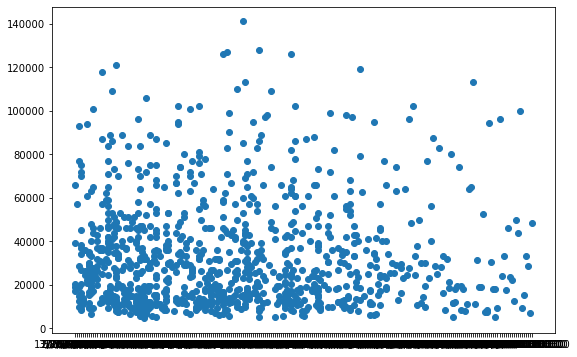

In [6]:
# visulaizing saledate vs SalePrice features
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])
plt.show()

In [7]:
df.saledate[:1000], df.saledate.dtype # data type of saledate feature is object which contains date of sale of bulldozer

(0      11/16/2006 0:00
 1       3/26/2004 0:00
 2       2/26/2004 0:00
 3       5/19/2011 0:00
 4       7/23/2009 0:00
             ...       
 995     7/16/2009 0:00
 996     6/14/2007 0:00
 997     9/22/2005 0:00
 998     7/28/2005 0:00
 999     6/16/2011 0:00
 Name: saledate, Length: 1000, dtype: object, dtype('O'))

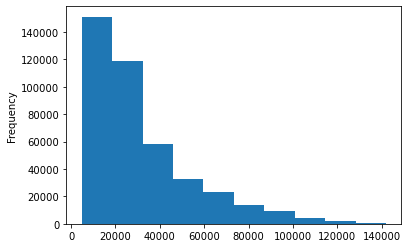

In [8]:
# Let's see distribution range of Target variable
df.SalePrice.plot.hist();

## Parsing dates

when we work with time series data, we want to enrich time and date component as much as possible.

we can do it using pandas where columns has dates in dataframe can be parsed using `parse_dates` parameter.

In [9]:
# import data again with parsing dates

df = pd.read_csv('data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [10]:
df.saledate.dtype

dtype('<M8[ns]')

In [11]:
df.saledate[:1000]  # Converted into pandas dateTime object

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

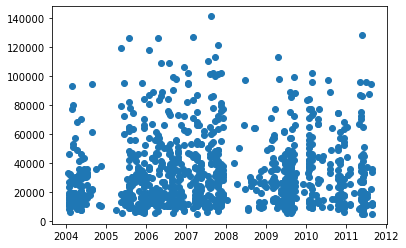

In [12]:
# Now lets visualize the same plot as above
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

# Comparing above and below plot..since dates are parsed,plot looks perfect

In [13]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort Dataframe by Saledate

when working with time series data, it is good to Sort the data by date.

In [15]:
# Sort Dataframe in date order
df.sort_values(by=['saledate'],inplace=True, ascending=True)

df.saledate.head(20)  # Viewing 20 samples

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [17]:
df.head() # We can see indexing has been changed due to sorting

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Making a copy of original dataframe

We can make a copy of original dataframe so when we manipulate the copy, we've still got our original data.

In [18]:
# make a copy 

df_tmp = df.copy()

### Add a datetime parameters for `saledate` column

Extracting features of `saledate` column to get more insights on the dataset

In [19]:
# Example for extracting only year from saledate

df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int64

In [20]:
# Example for extracting only day from saledate

df_tmp[:1].saledate.dt.day

205615    17
Name: saledate, dtype: int64

In [21]:
# Adding the extracted columns to the dataframe

df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear


In [22]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [23]:
# So now we'have enriched our dataframe with date time features, so we can drop saledate column

df_tmp.drop('saledate',axis=1,inplace=True)

In [24]:
# Checking the categories of state feature

df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [25]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,D38E,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2064,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,337G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,12G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


# 5.Modelling

we've done enough EDA(but we can do more), Let's do model driven EDA.

In [26]:
# Splitting the data into train and validation datasets

"""
Data is splitted as mentioned in kaggle
Train.csv is the training set, which contains data through the end of 2011.
Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 
"""

df_val = df_tmp[df_tmp['saleYear'] == 2012]
df_train = df_tmp[df_tmp['saleYear'] !=2012]


# splitting  data into X and y

X_train, y_train = df_train.drop('SalePrice',axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice',axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

In [27]:
# Let's build a Machine Learning model

'''
Since target variable is SalePrice which means our aim is to predict the price, henceforth
Regression type models has to be used
'''

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42) # n_jobs = -1 since data is very huge, system needs all core processors to run model

model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Low'

**Note:**

*From Above Error, it indicates that string type data is present in dataset. So for any model to be driven
our dataset to be fully numeric*

## Converting string data type to Categories and filling missing values

1. One way we can turn all our data into numbers is by converting them into Pandas categories.
2. Filling the numeric missing values with median of respective feature
3. Filling the missing values of categories with codes(given by pandas)

we can check different data types compatible with pandas here:
https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html

In [28]:
# Function to convert missing values of dataframe and also converting features to pandas categories

def preprocesss_data(df):
    """
    Performs transformtaion on df and returns the transformed df.
    """
    
    #Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Filling numerical missing values with median
                df[label] = content.fillna(content.median())
            
        # Filling categorical missing data and turn categories into numbers
        
        if not pd.api.types.is_numeric_dtype(content):
            # we will add +1 to categorical code because pandas encodes missing values as -1
            df[label] = pd.Categorical(content).codes + 1
        
    return df

In [29]:
# Calling preprocess function to fill all missing values in training and vaildation data

X_train = preprocesss_data(X_train)
X_valid = preprocesss_data(X_valid)

In [30]:
# To check whether missing data are filled or not
X_train.isna().sum()

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper                      0
Scarifier 

In [31]:
# To check whether missing data are filled or not
X_valid.isna().sum()

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper                      0
Scarifier 

**Now that all of our data is numeric as well as our dataframe has no missing values, we should 
able to build ML model.**

**RandomForestRegressor** model is choosed based on sklearn model map https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [32]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Instantiate RandomForestRegressor model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model for training data
model.fit(X_train, y_train)

Wall time: 5min 19s


In [33]:
# Evaluating score of model
model.score(X_valid, y_valid)

0.49353143527165466

# Building an Evaluation Function

In [34]:
# Create evaluation function (competition uses RMSLE)

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    calculates root mean squared log error between predicted values 
    and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores ={"Training MAE": mean_absolute_error(y_train,train_preds),
             "Validation MAE": mean_absolute_error(y_valid, valid_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Validation RMSLE": rmsle(y_valid, valid_preds),
             "Training R^2": r2_score(y_train, train_preds),
             "Validation R^2": r2_score(y_valid, valid_preds)}
    return scores


## Hyperparamter tuning with RandomizedSearchCV

Randomized search on hyper parameters to tune the model

In [36]:
%%time

from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
           'max_depth': [None,3,5,10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf':np.arange(1,20,2),
           'max_features':[0.5,1,'sqrt','auto'],
           'max_samples':[10000]}

#Instantiate
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),
                         param_distributions=rf_grid,
                         n_iter=5,
                         cv=5,
                         verbose=True)

#Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.0min finished


Wall time: 3min 5s


In [38]:
# Find the best hyper params from above training

rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [39]:
# Evaluate the RandomizedSearchCV model

show_scores(rs_model)  

{'Training MAE': 6548.120488442456,
 'Validation MAE': 10213.1964585972,
 'Training RMSLE': 0.2940992488748353,
 'Validation RMSLE': 0.40329101950961777,
 'Training R^2': 0.8147404625600486,
 'Validation R^2': 0.6424865859939406}

## Train model with best hyperparams

**Note:** Below hyperparamters are found after research using `RandomizedSearchCV` with `n_iter=100` and `max_samples=None`

In [40]:
%%time

#Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                   random_state=42,
                                   min_samples_leaf =3,
                                   min_samples_split=16,
                                   max_features=0.5,
                                   max_depth=None,
                                   n_jobs=-1,
                                   max_samples=None)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 1min 1s


In [41]:
# Scores of ideal model(above model)

show_scores(ideal_model)

{'Training MAE': 3261.2146598763816,
 'Validation MAE': 10599.890400272814,
 'Training RMSLE': 0.15954097437092646,
 'Validation RMSLE': 0.4106581397838066,
 'Training R^2': 0.9484500425192995,
 'Validation R^2': 0.6097520965234067}

> **We have achieved root mean squared log error(RMSLE) score of 0.41 for validation data, which makes us to stand around 90th position in Leaderboard of the competition**

In [43]:
# Scores on rs_model (only trained on 10,000 samples)

show_scores(rs_model)

{'Training MAE': 6548.120488442458,
 'Validation MAE': 10213.1964585972,
 'Training RMSLE': 0.2940992488748353,
 'Validation RMSLE': 0.40329101950961777,
 'Training R^2': 0.8147404625600487,
 'Validation R^2': 0.6424865859939407}

**Till now we have predicted on validation dataset and tuned our model based on predictions**

## Make prediction on test data

In [44]:
# Import the test data

df_test = pd.read_csv('data/Test.csv',low_memory=False,parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Lets compare our training data with test data....

In [45]:
df_test.info()  #Non numeric data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [46]:
df_test.isnull().sum()  #Missing values

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [47]:
len(df_test.columns),  len(X_train.columns)  # Difference in columns of both data sets

(52, 56)

## Preprocessing the data( Getiing the test dataset in same format as our train dataset)

In [48]:
def preprocesss_data(df):
    """
    Performs transformtaion on df and returns the transformed df.
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop('saledate',axis=1, inplace=True)
    
    #Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                
                df[label] = content.fillna(content.median())
            
        # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):

            # we will add +1 to categorical code because pandas encodes missing values as -1
            df[label] = pd.Categorical(content).codes + 1
        
    return df
    
    

In [49]:
# Preprocess the test data
df_test = preprocesss_data(df_test)
df_test.head().T

,0,1,2,3,4
SalesID,1227829.0,1227844.0,1227847.0,1227848.0,1227863.0
MachineID,1006309.0,1022817.0,1031560.0,56204.0,1053887.0
ModelID,3168.0,7271.0,22805.0,1269.0,22312.0
datasource,121.0,121.0,121.0,121.0,121.0
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,1999.0,1000.0,2004.0,2006.0,2005.0
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,2.0,1.0,3.0,1.0,2.0
fiModelDesc,499.0,831.0,1177.0,287.0,566.0
fiBaseModel,180.0,292.0,404.0,113.0,196.0


In [50]:
# Let's make predictions on test data

test_preds = ideal_model.predict(df_test)
test_preds

array([17601.71633003, 15952.75562513, 48630.47856948, ...,
       14174.18392855, 17762.92324049, 25172.39598833])

In [51]:
len(test_preds)

12457

lets format the predictions as kaggle has asked. https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [52]:
#Formating predictions

df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalePrice'] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,17601.716330
1,1227844,15952.755625
2,1227847,48630.478569
3,1227848,63465.412722
4,1227863,51378.135345
...,...,...
12452,6643171,40274.390505
12453,6643173,13679.535910
12454,6643184,14174.183929
12455,6643186,17762.923240


**We cannot find the R^2 or RMSLE value of test data since we do not know the truth values of test data**

## Feature Importance

It figures out which attributes/features of data were of most important when it comes to predicting **target variable** (saleprice)

In [53]:
# Finding feature importance of our best model

'''
These are impurity based feature importances with respect to target variable
for RandomForestRegressor model
'''
ideal_model.feature_importances_,   len(ideal_model.feature_importances_)

(array([3.40018204e-02, 1.58693205e-02, 4.98792986e-02, 2.12365762e-03,
        2.84124030e-03, 2.05940410e-01, 2.95499671e-03, 1.03839638e-03,
        3.94607531e-02, 5.23047973e-02, 6.74988047e-02, 6.25383784e-03,
        3.52156169e-02, 1.78460949e-01, 4.59920531e-02, 5.05211186e-03,
        6.18832707e-03, 4.79666580e-03, 3.45904496e-03, 4.13842178e-02,
        4.39448606e-04, 3.51622434e-05, 1.57517848e-03, 2.20706084e-04,
        1.12302343e-03, 2.05922450e-03, 4.34412391e-03, 7.30602996e-03,
        1.38718255e-03, 1.17150563e-03, 7.56218226e-03, 7.64976855e-03,
        3.55596424e-03, 1.20773514e-03, 2.59557927e-03, 1.98104161e-02,
        1.24227781e-03, 2.06833168e-02, 7.49561851e-03, 3.23271285e-03,
        1.88341230e-03, 8.89021019e-04, 2.39547885e-03, 5.71319225e-04,
        7.58844742e-04, 3.37177082e-04, 5.65687862e-04, 2.15369745e-03,
        1.06236569e-03, 2.75895284e-04, 3.26008379e-04, 7.38847192e-02,
        3.49626130e-03, 4.74247167e-03, 2.38217429e-03, 8.861988

In [54]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features':columns,
                       'Feature_importances':importances})
          .sort_values('Feature_importances',ascending=False)
          .reset_index(drop=True)) #This is called chaining in pandas
    
    #plot the dataframe
    fig, ax =plt.subplots(figsize=(15,10))
    ax.barh(df['features'][:n], df['Feature_importances'][:n])
    ax.set_xlabel('Feature Importances')
    ax.set_ylabel('Features')
    ax.invert_yaxis() # To get high score in top position
    

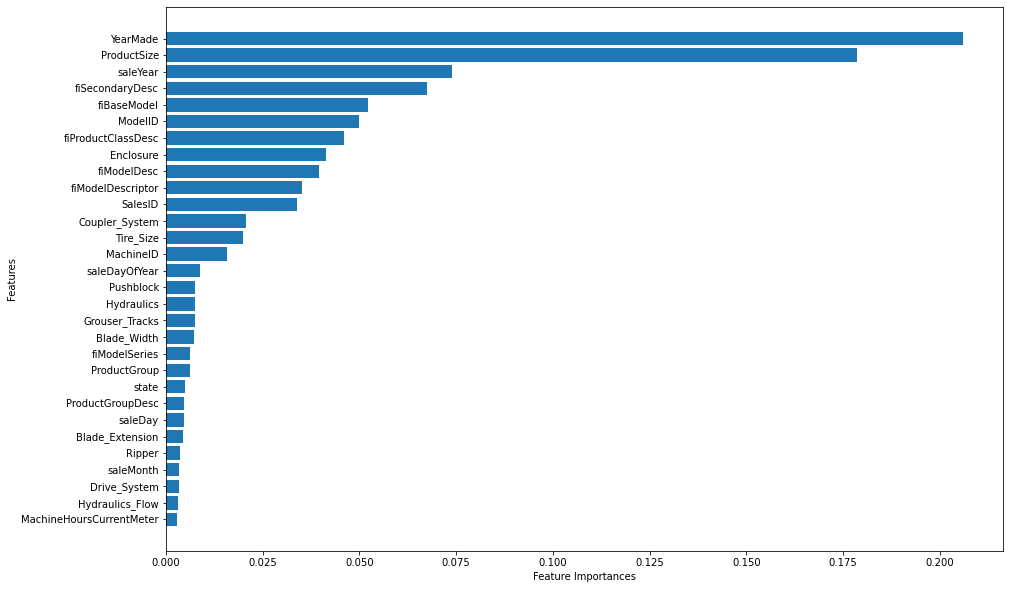

In [56]:
# Viewing first 30 features of the ideal model

plot_features(X_train.columns, ideal_model.feature_importances_, 30)

**Above plot shows that which of the features has more importance towards predicting SalePrice of Bulldozer for RandomForestRegressor model**